In [4]:
!pip install pytorch_lightning

You should consider upgrading via the '/home/oana/.pyenv/versions/3.8.6/envs/action_order/bin/python3.8 -m pip install --upgrade pip' command.


In [1]:
import pytorch_lightning as pl
print(pl.__version__)

1.6.0dev


/home/oana/.pyenv/versions/3.8.6/envs/action_order/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [2]:
import json
import sys
from typing import Any, List, Mapping

import requests

if '..' not in sys.path:
    sys.path.append('..')

from lqam.methods.dataset import URL_DATA_TEST, URL_DATA_VAL
from lqam.util.file_utils import cached_path

def load_data_from_link(link: str) -> List[Mapping[str, Any]]:
    with open(cached_path(link)) as file:
        return json.load(file)

val_data = load_data_from_link(URL_DATA_VAL)
test_data = load_data_from_link(URL_DATA_TEST)
annotated_data = val_data + test_data

In [3]:
print(len(annotated_data))

1985


In [4]:
## normalize all data
import sys
if('..' not in sys.path):
    sys.path.append('..')
from lqam.core.metrics import normalize_answer
for data_i in annotated_data:
    data_i['label_norm'] = normalize_answer(data_i['label'])
    data_i['annotations_norm'] = [[normalize_answer(y) for y in x] for x in data_i['additional_answers']]

### Noun distribution

Let's look at the top-K nouns for (1) ground-truth data and (2) labeled data.

In [5]:
import pandas as pd
ground_truth_labels = list(map(lambda x: x['label_norm'], annotated_data))
ground_truth_label_counts = pd.Series(ground_truth_labels).value_counts()
display(ground_truth_label_counts.head(20))

man          113
person        56
woman         50
it            46
people        31
group         22
he            20
someone       19
boy           19
them          18
girl          17
front         17
young man     13
camera        13
table         12
piece         12
baby          11
ball          11
child         11
music         10
dtype: int64

In [6]:
from functools import reduce
annotation_labels = []
for annotated_data_i in annotated_data:
    annotations_i = set()
    for annotations_j in annotated_data_i['annotations_norm']:
        # remove duplicate annotations
        annotations_i.update(annotations_j)
    annotation_labels.extend(list(annotations_i))
annotation_label_counts = pd.Series(annotation_labels).value_counts()
display(annotation_label_counts.head(20))

person       409
man          310
guy          230
someone      226
woman        173
girl         156
people       152
boy          142
kid          132
male         129
lady         128
child        126
room          89
group         87
female        83
kids          79
it            76
human         73
gentleman     71
adult         62
dtype: int64

In [7]:
## combine counts for table
combined_label_counts = pd.concat([
    ground_truth_label_counts.reset_index().head(10),
    annotation_label_counts.reset_index().head(10),
], axis=1)
print(combined_label_counts.to_latex(index=False))

\begin{tabular}{lrlr}
\toprule
  index &   0 &   index &   0 \\
\midrule
    man & 113 &  person & 409 \\
 person &  56 &     man & 310 \\
  woman &  50 &     guy & 230 \\
     it &  46 & someone & 226 \\
 people &  31 &   woman & 173 \\
  group &  22 &    girl & 156 \\
     he &  20 &  people & 152 \\
someone &  19 &     boy & 142 \\
    boy &  19 &     kid & 132 \\
   them &  18 &    male & 129 \\
\bottomrule
\end{tabular}



In [8]:

## plot combined word counts
## compute percent values, 
combined_label_pct = pd.concat([
    ground_truth_label_counts / ground_truth_label_counts.sum() * 100,
    annotation_label_counts / annotation_label_counts.sum() * 100,
], axis=1).fillna(0., inplace=False)
combined_label_pct.columns = ['label', 'annotation']
combined_label_pct = combined_label_pct.assign(**{'joint_pct' : combined_label_pct.mean(axis=1)})
combined_label_pct.sort_values('joint_pct', inplace=True, ascending=False)

top_k = 30
combined_label_pct = combined_label_pct.reset_index(inplace=False).rename(columns={'index':'word'})

top_k_words = combined_label_pct.loc[:, 'word'].iloc[:top_k]
display(combined_label_pct.head())

,word,label,annotation,joint_pct
0,man,5.692695,1.197235,3.444965
1,person,2.821159,1.579577,2.200368
2,woman,2.518892,0.668134,1.593513
3,it,2.317380,0.293516,1.305448
4,people,1.561713,0.587031,1.074372


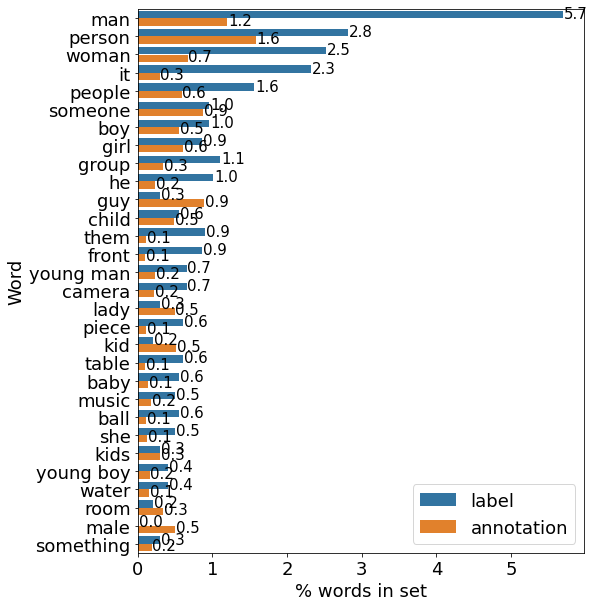

In [9]:
flat_combined_label_pct = pd.melt(combined_label_pct, id_vars=['word'], value_vars=['label', 'annotation'], value_name='word_pct', var_name='data_type')
top_k_flat_combined_label_pct = flat_combined_label_pct[flat_combined_label_pct.loc[:, 'word'].isin(top_k_words)]


import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## main bar plot
plt.figure(figsize=(8, 10))
ax = sns.barplot(x='word_pct', y='word', hue='data_type', data=top_k_flat_combined_label_pct)
plt.xlabel('% words in set', fontsize=18)
plt.ylabel('Word', fontsize=18)
plt.legend(loc='lower right', fontsize=18)

for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(18)

# plt.title('Top word counts for labels and annotations', fontsize=18)
## text annotations
y_idx = plt.yticks()[0]
x_offset = top_k_flat_combined_label_pct.loc[:, 'word_pct'].max() * 3e-2
y_offset = (y_idx[1] - y_idx[0]) * 0.35
# add counts on top of bars
for i, word_i in enumerate(top_k_words):
    data_i = top_k_flat_combined_label_pct[top_k_flat_combined_label_pct.loc[:, 'word']==word_i]
    label_data_i = data_i[data_i.loc[:, 'data_type']=='label'].iloc[0, :]
    annotation_data_i = data_i[data_i.loc[:, 'data_type']=='annotation'].iloc[0, :]    
    # plot label, annotation counts separately
    ax.text(y=y_idx[i], x=label_data_i.loc['word_pct']+x_offset, s='{:1.1f}'.format(label_data_i.loc['word_pct']), color='black', ha='center', fontsize=15)
    ax.text(y=y_idx[i]+y_offset, x=annotation_data_i.loc['word_pct']+x_offset, s='{:1.1f}'.format(annotation_data_i.loc['word_pct']), color='black', ha='center', fontsize=15)
plt.show()

In [10]:

## plot both distributions
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
def plot_word_distribution(word_counts, plot_name):
    plt.barh(word_counts.index, word_counts.values)
    plt.xlabel('Count')
    plt.title(f'Top counts for {plot_name}')
    plt.show()

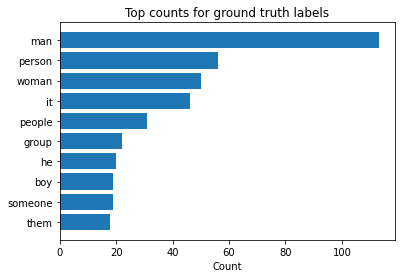

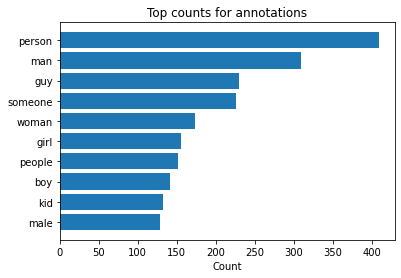

In [11]:
top_k = 10
plot_word_distribution(ground_truth_label_counts.head(top_k).sort_values(ascending=True), 'ground truth labels')
plot_word_distribution(annotation_label_counts.head(top_k).sort_values(ascending=True), 'annotations')

In [12]:
top_k = 50
annotation_label_counts.head(top_k).sort_values(ascending=False)

person            409
man               310
guy               230
someone           226
woman             173
girl              156
people            152
boy               142
kid               132
male              129
lady              128
child             126
room               89
group              87
female             83
kids               79
it                 76
human              73
gentleman          71
adult              62
crowd              61
young man          61
he                 59
men                59
friends            58
video              58
camera             57
worker             56
children           56
athlete            54
teenager           52
ground             51
object             51
something          48
women              47
tool               47
dude               47
guys               46
music              46
audience           44
boys               43
building           42
individual         42
another person     41
young boy          41
food      

In [13]:
for data in annotated_data:
    flat_list = [item for sublist in data["additional_answers"] for item in sublist]
#     print(flat_list)
    if "another person" in flat_list:
        print(data["masked_caption"])
        print(data["label"])

A woman plays a flute while _____ is playing a harp instrument.
another woman
A man and _____ express happiness as they ride a sleigh down a hill.
a boy
On a road, a girl is pushing _____ sitting on a three-wheel wheelbarrow.
another girl
A man is seen doing sit-ups while his legs are held down by _____.
another person
A person is seen performing a back massage on _____.
an individual
A potter dits at his wheel as _____ slows and lift a pot off it and hands it to a woman sitting opposite him, as both pose for the camera.
it
A man has his name called by _____ on a microphone and stands to receive a bouqet of flowers.
someone
A person on a golf course hitting the ball into the hole in front of _____.
them
Music plays while a young woman shows her teeth, kisses _____ and shows picture collages.
another young woman
A small child bangs against a xylophone being held by _____.
a woman
A man is talking and _____ is stacking cards.
a boy
A teenage boy tosses a football at _____ who catches it 

#### Clustering answers

In [1]:
!pip install -U sentence-transformers  #https://github.com/UKPLab/sentence-transformers

     |████████████████████████████████| 78 kB 26 kB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 3.1 MB 990 kB/s            
  Using cached tokenizers-0.10.3-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (3.3 MB)
     |████████████████████████████████| 23.3 MB 4.0 MB/s            
     |████████████████████████████████| 25.9 MB 580 kB/s            
     |████████████████████████████████| 1.5 MB 4.6 MB/s            
     |████████████████████████████████| 1.2 MB 1.7 MB/s            
     |████████████████████████████████| 59 kB 4.6 MB/s            
     |████████████████████████████████| 764 kB 3.5 MB/s            
  Using cached sacremoses-0.0.46-py3-none-any.whl (895 kB)
     |████████████████████████████████| 306 kB 711 kB/s            
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=264782dbf84b0372f2d0d79984cfc413ad

In [2]:
from sentence_transformers import SentenceTransformer 
model = SentenceTransformer('stsb-roberta-base') # models: https://www.sbert.net/docs/pretrained_models.html#semantic-textual-similarity

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.92k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/672 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [56]:
top_k = 300
# sentence_labels = annotation_label_counts.head(top_k).sort_values(ascending=False).keys().tolist()
sentence_labels = list(set(annotation_label_counts.head(top_k).keys().tolist()))
# print(sentence_labels)
print(len(sentence_labels))

300


In [66]:
sentence_embeddings = model.encode(sentence_labels)
sentence_embeddings.shape

(300, 768)

In [67]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np

#Normalize the embeddings to unit length
sentence_embeddings = sentence_embeddings /  np.linalg.norm(sentence_embeddings, axis=1, keepdims=True)

# clustering_model = AgglomerativeClustering(n_clusters=None, distance_threshold=0.5) #, affinity='cosine', linkage='average', distance_threshold=0.4)
clustering_model = AgglomerativeClustering(n_clusters=4, affinity='cosine', linkage='average')

clustering_model.fit(sentence_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = {}
for sentence_id, cluster_id in enumerate(cluster_assignment):
    if cluster_id not in clustered_sentences:
        clustered_sentences[cluster_id] = []

    clustered_sentences[cluster_id].append(sentence_labels[sentence_id])

for i, cluster in clustered_sentences.items():
    print("Cluster ", i+1)
    print(cluster)
    print("")

Cluster  2
['teenagers', 'teenager', 'mom', 'humans', 'youth', 'student', 'adults', 'older woman', 'teen', 'groups', 'adolescent', 'group', 'person', 'two kids', 'adult', 'athlete', 'young lady', 'men', 'two friends', 'young man', 'family', 'another person', 'they', 'show', 'team', 'women', 'youngster', 'students', 'gaggle', 'himself', 'young woman', 'match', 'male', 'it', 'player', 'another man', 'hand', 'some guy', 'young girl', 'them', 'kid', 'two guys', 'two children', 'friends', 'athletes', 'daughter', 'little girl', 'baby', 'small child', 'others', 'he', 'gathering', 'someone', 'girls', 'infant', 'males', 'teams', 'girl', 'boys', 'young boy', 'group of people', 'some dude', 'she', 'audience', 'young child', 'guy', 'couple', 'people', 'female', 'fans', 'players', 'kids', 'his friend', 'older man', 'two men', 'young people', 'man', 'his hands', 'young men', 'someone else', 'her hands', 'brothers', 'game', 'children', 'human', 'little boy', 'siblings', 'child', 'his hand', 'young pe

In [55]:
def get_key_by_val(clusters, val):
    for k in clusters.keys():
        values = clusters[k]
        if val in values:
            return k

In [82]:
list_persons = list(set(['person', 'artist', 'host', 'chef', 'competitors', 'employee', "musician", "workers", "spectators", "viewers", "dancer", "trainer", "son", 'another person', "crowd", "band", "lady", "other people", "old man", "group of people", 'daughter', 'father', 'mother', 'children', 'teenager', 'infant', 'humans', 'youth', 'female', 'student', 'friend', "baby", "siblings", "herself", "audience", 'young man']))
list_bodys = list(set(['his hands', 'her head', 'his body', 'legs', 'hair', "fingers", 'her feet', 'head']))
list_Position = list(set(["front", "back", "right", "left"]))
list_Materials = list(set(['grass', 'sand', "metal", 'liquid', "paper", 'ice', 'wood', 'steel', 'dirt', 'carpet', 'pond', 'wall', 'rock', 'snow', 'fire', 'cloth']))
list_Objects = list(set(['glasses', 'bowl', 'dish', 'stick', 'pole', 'baseball', 'car', 'tube', 'brush', 'dish', 'desk',  'bed', 'hill', 'food', 'pan', 'table', 'musical instrument', 'shoes', 'equipment', 'board', 'liquid', 'tube', 'tree', 'toy']))
list_Places = list(set(['living room', 'kitchen' 'class', 'his house', 'studio', 'home', 'park', 'mountain', 'room', 'stage', 'field', 'backyard', 'courtyard', 'street', 'pavement', 'background', 'floor']))

clusters = {"Person related": list_persons,
            "Body parts": list_bodys,
            "Position": list_Position,
            "Materials": list_Materials,
            "Objects":list_Objects,
           "Places": list_Places}

In [83]:
clusters

{'Person related': ['teenager',
  'humans',
  'dancer',
  'group of people',
  'youth',
  'trainer',
  'old man',
  'student',
  'viewers',
  'person',
  'competitors',
  'lady',
  'other people',
  'herself',
  'musician',
  'spectators',
  'audience',
  'workers',
  'daughter',
  'mother',
  'young man',
  'female',
  'chef',
  'artist',
  'friend',
  'baby',
  'another person',
  'father',
  'crowd',
  'son',
  'children',
  'siblings',
  'employee',
  'infant',
  'band',
  'host'],
 'Body parts': ['her feet',
  'legs',
  'hair',
  'fingers',
  'her head',
  'his hands',
  'head',
  'his body'],
 'Position': ['back', 'right', 'left', 'front'],
 'Materials': ['cloth',
  'dirt',
  'rock',
  'ice',
  'paper',
  'pond',
  'liquid',
  'steel',
  'grass',
  'wall',
  'wood',
  'carpet',
  'fire',
  'sand',
  'metal',
  'snow'],
 'Objects': ['glasses',
  'brush',
  'car',
  'toy',
  'bowl',
  'board',
  'bed',
  'liquid',
  'dish',
  'hill',
  'pan',
  'desk',
  'food',
  'tube',
  'tree',

In [84]:
import random
import seaborn as sns

def make_color_dict(clusters):  #TODO: color_list should be changed to automatic list based on number of clusters
    color_dict = {}
    # color_list = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    color_list = []
    color_list = sns.color_palette("hls", len(clusters))
    n = len(clusters)
    # for i in range(n):
    #     r = random.randint(0, 10)
    #     g = random.randint(0, 10)
    #     b = random.randint(0, 10)
    #     color_list.append((float(r)/10, float(g)/10, float(b)/10))
    for i, key in enumerate(clusters.keys()):
        color_dict[key] = color_list[i]
    return color_dict

In [85]:
from sklearn.manifold import TSNE # This transforms the data from a high dimensional vector (768d in this case) to a 2d one, https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0) #n_components is the dimension of the vector
sentence_embeddings_proj_2d = tsne.fit_transform(sentence_embeddings)


/home/oana/.pyenv/versions/3.8.6/envs/action_order/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [86]:
!pip install adjustText

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [93]:
import matplotlib.pyplot as plt  #TODO: play around with the parameters - figure size, font size, etc
import random
from adjustText import adjust_text # this package corrects the label overlap. I installed it with conda/ pip in my virtual env


def tsne_plot_2d(clusters, embeddings, words):
    plt.figure(figsize=(16, 13))
    color_dict = make_color_dict(clusters)
    texts = []
    cluster_dict = {}
    for embedding, word in zip(embeddings, words):
        x = embedding[0]
        y = embedding[1]
#         print(word)
#         verb = word.split(" ")[0]
        dobj = word

#         print(dobj)
        cluster_key = get_key_by_val(clusters, dobj)
        if not cluster_key:
            continue
#         print(cluster_key)
        color = color_dict[cluster_key]
        
        if cluster_key not in cluster_dict:
            plt.scatter(x, y, color=color,s=100, label=cluster_key)
            cluster_dict[cluster_key] = []
        else:
            plt.scatter(x, y, color=color, s=100)
        cluster_dict[cluster_key].append((x, y, dobj))
            
    for id in cluster_dict:
        # points = random.choices(cluster_dict[id], weights=None, cum_weights=None, k=2)
        points = cluster_dict[id]
        # print(id, points)
        for point in points:
            # texts.append(plt.text(point[0], point[1], id + " " + point[2], ha='right', va='bottom', size=12, color = color_dict[id], wrap=True))
            # texts.append(plt.text(point[0], point[1], id + " " + point[2], ha='right', va='bottom', size=12, color = color_dict[id]))
            texts.append(plt.text(point[0], point[1], point[2], ha='right', va='bottom', size=21, color = color_dict[id], wrap=True))
    adjust_text(texts)
    # plt.grid(True)
    # plt.legend(loc=1, prop={'size': 15})
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          ncol=6, shadow=True, prop={'size': 18})
    # Turn off tick labels
    plt.yticks([])
    plt.xticks([])
#     plt.title("Clustering example of most frequent fill-in-blanks annotations", fontsize=20, y=1.01)
#     plt.show()
    plt.savefig("data/clusters.pdf", bbox_inches = "tight")

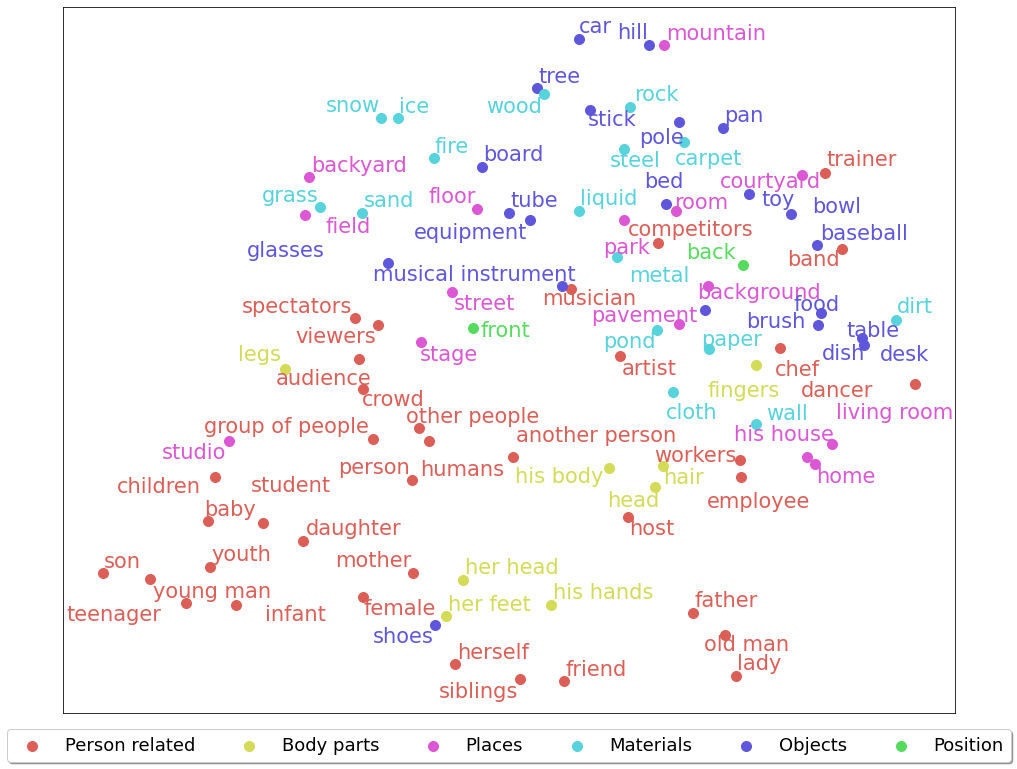

In [94]:
tsne_plot_2d(clusters, sentence_embeddings_proj_2d, sentence_labels)